In [1]:
import pandas as pd
import wikipedia as wp
import numpy as np
import json
from geopy.geocoders import Nominatim
import requests # library to handle requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
#Download html page using wikipedia package
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df1 = pd.read_html(html)[0]
# Replacing the name of the neighbourhoods which are 'Not assigned' with the names of corresponsing Borough
df1['Neighborhood'] = np.where(df1['Neighborhood'] == 'Not assigned',df1['Borough'], df1['Neighborhood'])
# Dropping the rows where Borough is 'Not assigned'
df1 = df1[df1.Borough != 'Not assigned']


df1

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [3]:
# Combining the neighbourhoods with the same Postalcode
df2 = df1.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

df2=df2.drop(columns=['Borough'])

df2

,Postal Code,Neighborhood
0,M3A,Parkwoods
1,M4A,Victoria Village
2,M5A,"Regent Park, Harbourfront"
3,M6A,"Lawrence Manor, Lawrence Heights"
4,M7A,"Queen's Park, Ontario Provincial Government"
...,...,...
98,M8X,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Church and Wellesley
100,M7Y,"Business reply mail Processing Centre, South C..."
101,M8Y,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


split_df2 = df2['Neighborhood'].apply(lambda x: pd.Series(x.split(',')))
split_df2

df_3 = pd.concat([df2,split_df2], axis=1)
df_3

In [4]:
#Read geospatial data and merge it with the exisiting dataframe
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')

lat_lon.rename(columns={'Postal Code':'Postal Code'},inplace=True)
df4 = pd.merge(df2,lat_lon,on='Postal Code')
df4.head()



,Postal Code,Neighborhood,Latitude,Longitude
0,M3A,Parkwoods,43.753259,-79.329656
1,M4A,Victoria Village,43.725882,-79.315572
2,M5A,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [5]:
#Creating map with folium
map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

for lat,lng,neighbourhood in zip(df4['Latitude'],df4['Longitude'],df4['Neighborhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

In [6]:
df_pet = pd.read_excel(r'C:\Users\Rohit\Desktop\by-forward-sortation-area-fsa-2017.xlsx', sheet_name='Sheet1')
df5=pd.merge(df4,df_pet, left_on='Postal Code', right_on='FSA', how="inner")
df5

,Postal Code,Neighborhood,Latitude,Longitude,FSA,CAT,DOG,Total
0,M3A,Parkwoods,43.753259,-79.329656,M3A,309,646,955
1,M4A,Victoria Village,43.725882,-79.315572,M4A,93,210,303
2,M5A,"Regent Park, Harbourfront",43.654260,-79.360636,M5A,416,949,1365
3,M6A,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,M6A,147,241,388
4,M9A,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,M9A,360,986,1346
...,...,...,...,...,...,...,...,...
92,M4X,"St. James Town, Cabbagetown",43.667967,-79.367675,M4X,162,366,528
93,M8X,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,M8X,153,441,594
94,M4Y,Church and Wellesley,43.665860,-79.383160,M4Y,237,604,841
95,M8Y,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,M8Y,286,708,994


In [7]:
df_pop = pd.read_csv(r'C:\Users\Rohit\Desktop\population_fsa.csv')
df6=pd.merge(df5,df_pop, left_on='Postal Code', right_on='Geographic code', how="inner")
df6

,Postal Code,Neighborhood,Latitude,Longitude,FSA,CAT,DOG,Total,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,M3A,Parkwoods,43.753259,-79.329656,M3A,309,646,955,M3A,M3A,Ontario,NaN,34615.0,13847.0,13241.0
1,M4A,Victoria Village,43.725882,-79.315572,M4A,93,210,303,M4A,M4A,Ontario,NaN,14443.0,6299.0,6170.0
2,M5A,"Regent Park, Harbourfront",43.654260,-79.360636,M5A,416,949,1365,M5A,M5A,Ontario,NaN,41078.0,24186.0,22333.0
3,M6A,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,M6A,147,241,388,M6A,M6A,Ontario,NaN,21048.0,8751.0,8074.0
4,M9A,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,M9A,360,986,1346,M9A,M9A,Ontario,NaN,35594.0,15730.0,15119.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,M4X,"St. James Town, Cabbagetown",43.667967,-79.367675,M4X,162,366,528,M4X,M4X,Ontario,NaN,20822.0,10809.0,10306.0
93,M8X,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,M8X,153,441,594,M8X,M8X,Ontario,NaN,10787.0,4680.0,4523.0
94,M4Y,Church and Wellesley,43.665860,-79.383160,M4Y,237,604,841,M4Y,M4Y,Ontario,NaN,30472.0,21975.0,19665.0
95,M8Y,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,M8Y,286,708,994,M8Y,M8Y,Ontario,NaN,21299.0,10485.0,9782.0


In [8]:
CLIENT_ID="3HROTGPRJVVYFZDU2GRKWJTRBUOFZ5SYXBQN5W14DLNMJVD2"
CLIENT_SECRET="ZQPXLR4Z0014SN0A3DFZ3QM2V0XJTJFDYLL1MYB2HOLIOOGT"
redirect_id="www.coursera.com"
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)  
    
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    '''Call FourSquare api to retrieve nearby Pet Stores and Pet services'''
    
    venues_list=[]
    categoryID='4bf58dd8d48988d100951735,5032897c91d4c4b30a586d69' # pet services and petstore
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryID)
        #print(requests.get(url).json())
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print('Your quota may have been exceeded')
            return
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



Your credentails:
CLIENT_ID: 3HROTGPRJVVYFZDU2GRKWJTRBUOFZ5SYXBQN5W14DLNMJVD2
CLIENT_SECRET:ZQPXLR4Z0014SN0A3DFZ3QM2V0XJTJFDYLL1MYB2HOLIOOGT


In [13]:
LIMIT=100
radius = 1000

toronto_venues = getNearbyVenues(names=df6['Neighborhood'],latitudes=df6['Latitude'],longitudes=df6['Longitude'],radius=radius)

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danfo

In [14]:
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,PetSmart,43.748639,-79.333488,Pet Store
1,Parkwoods,43.753259,-79.329656,Fab Fido Dog Grooming Spaw,43.760547,-79.325212,Pet Service
2,Victoria Village,43.725882,-79.315572,Personal Paws,43.724390,-79.308764,Pet Service
3,Victoria Village,43.725882,-79.315572,A1TailWaggers Incorporated,43.728318,-79.324142,Pet Service
4,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto Humane Society,43.657698,-79.356583,Pet Store
...,...,...,...,...,...,...,...
203,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,Chateau Pooch,43.642348,-79.491455,Pet Service
204,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,Barkyard,43.627802,-79.495950,Pet Service
205,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Toronto Animal Eye Clinic,43.633949,-79.520789,Pet Service
206,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Pet Valu,43.624136,-79.511427,Pet Store


In [15]:
df7=pd.merge(toronto_venues, df6, left_on='Neighborhood', right_on='Neighborhood', how="left")
df7

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Postal Code,Latitude,Longitude,...,CAT,DOG,Total,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,Parkwoods,43.753259,-79.329656,PetSmart,43.748639,-79.333488,Pet Store,M3A,43.753259,-79.329656,...,309,646,955,M3A,M3A,Ontario,NaN,34615.0,13847.0,13241.0
1,Parkwoods,43.753259,-79.329656,Fab Fido Dog Grooming Spaw,43.760547,-79.325212,Pet Service,M3A,43.753259,-79.329656,...,309,646,955,M3A,M3A,Ontario,NaN,34615.0,13847.0,13241.0
2,Victoria Village,43.725882,-79.315572,Personal Paws,43.724390,-79.308764,Pet Service,M4A,43.725882,-79.315572,...,93,210,303,M4A,M4A,Ontario,NaN,14443.0,6299.0,6170.0
3,Victoria Village,43.725882,-79.315572,A1TailWaggers Incorporated,43.728318,-79.324142,Pet Service,M4A,43.725882,-79.315572,...,93,210,303,M4A,M4A,Ontario,NaN,14443.0,6299.0,6170.0
4,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto Humane Society,43.657698,-79.356583,Pet Store,M5A,43.654260,-79.360636,...,416,949,1365,M5A,M5A,Ontario,NaN,41078.0,24186.0,22333.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,Chateau Pooch,43.642348,-79.491455,Pet Service,M8Y,43.636258,-79.498509,...,286,708,994,M8Y,M8Y,Ontario,NaN,21299.0,10485.0,9782.0
208,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,Barkyard,43.627802,-79.495950,Pet Service,M8Y,43.636258,-79.498509,...,286,708,994,M8Y,M8Y,Ontario,NaN,21299.0,10485.0,9782.0
209,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Toronto Animal Eye Clinic,43.633949,-79.520789,Pet Service,M8Z,43.628841,-79.520999,...,294,612,906,M8Z,M8Z,Ontario,NaN,17038.0,7046.0,6782.0
210,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Pet Valu,43.624136,-79.511427,Pet Store,M8Z,43.628841,-79.520999,...,294,612,906,M8Z,M8Z,Ontario,NaN,17038.0,7046.0,6782.0


In [16]:
df8 = pd.DataFrame(df7.groupby(['Postal Code', 'Neighborhood','Population, 2016','Total', 'Neighborhood Latitude','Neighborhood Longitude'])['Venue'].agg('count'))

In [22]:
df8.reset_index(inplace=True)
df8

,Postal Code,Neighborhood,"Population, 2016",Total,Neighborhood Latitude,Neighborhood Longitude,Venue
0,M1B,"Malvern, Rouge",66108.0,912,43.806686,-79.194353,2
1,M1C,"Rouge Hill, Port Union, Highland Creek",35626.0,1072,43.784535,-79.160497,1
2,M1E,"Guildwood, Morningside, West Hill",46943.0,1430,43.763573,-79.188711,3
3,M1H,Cedarbrae,24383.0,464,43.773136,-79.239476,1
4,M1J,Scarborough Village,36699.0,618,43.744734,-79.239476,1
...,...,...,...,...,...,...,...
70,M9B,"West Deane Park, Princess Gardens, Martin Grov...",32400.0,1326,43.650943,-79.554724,2
71,M9C,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",38291.0,1442,43.643515,-79.577201,2
72,M9L,Humber Summit,11950.0,197,43.756303,-79.565963,2
73,M9N,Weston,25074.0,688,43.706876,-79.518188,1


In [18]:
df9_no_pet=pd.merge(df6,df8, left_on='Postal Code', right_on='Postal Code', how="left")
df9_no_pet

,Postal Code,Neighborhood,Latitude,Longitude,FSA,CAT,DOG,Total,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016",Venue
0,M3A,Parkwoods,43.753259,-79.329656,M3A,309,646,955,M3A,M3A,Ontario,NaN,34615.0,13847.0,13241.0,2.0
1,M4A,Victoria Village,43.725882,-79.315572,M4A,93,210,303,M4A,M4A,Ontario,NaN,14443.0,6299.0,6170.0,2.0
2,M5A,"Regent Park, Harbourfront",43.654260,-79.360636,M5A,416,949,1365,M5A,M5A,Ontario,NaN,41078.0,24186.0,22333.0,7.0
3,M6A,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,M6A,147,241,388,M6A,M6A,Ontario,NaN,21048.0,8751.0,8074.0,3.0
4,M9A,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,M9A,360,986,1346,M9A,M9A,Ontario,NaN,35594.0,15730.0,15119.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,M4X,"St. James Town, Cabbagetown",43.667967,-79.367675,M4X,162,366,528,M4X,M4X,Ontario,NaN,20822.0,10809.0,10306.0,3.0
93,M8X,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,M8X,153,441,594,M8X,M8X,Ontario,NaN,10787.0,4680.0,4523.0,4.0
94,M4Y,Church and Wellesley,43.665860,-79.383160,M4Y,237,604,841,M4Y,M4Y,Ontario,NaN,30472.0,21975.0,19665.0,6.0
95,M8Y,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,M8Y,286,708,994,M8Y,M8Y,Ontario,NaN,21299.0,10485.0,9782.0,2.0


In [86]:
toronto_fsa_no_venues=df9_no_pet[(df9_no_pet['Venue'].isna())]
toronto_fsa_no_venues.count()

Postal Code                                                             22
Neighborhood                                                            22
Latitude                                                                22
Longitude                                                               22
FSA                                                                     22
CAT                                                                     22
DOG                                                                     22
Total                                                                   22
Geographic code                                                         22
Geographic name                                                         22
Province or territory                                                   22
Incompletely enumerated Indian reserves and Indian settlements, 2016     0
Population, 2016                                                        22
Total private dwellings, 

## There are a total of 22 neighborhoods where there is no petstore. These neighborhoods can be the places where petstores can be opened. Following is their list.

In [20]:
toronto_fsa_no_venues.reset_index(inplace=True)
toronto_fsa_no_venues

,index,Postal Code,Neighborhood,Latitude,Longitude,FSA,CAT,DOG,Total,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016",Venue
0,4,M9A,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,M9A,360,986,1346,M9A,M9A,Ontario,NaN,35594.0,15730.0,15119.0,NaN
1,15,M6C,Humewood-Cedarvale,43.693781,-79.428191,M6C,239,725,964,M6C,M6C,Ontario,NaN,24596.0,11043.0,10484.0,NaN
2,21,M1G,Woburn,43.770992,-79.216917,M1G,220,385,605,M1G,M1G,Ontario,NaN,29690.0,10116.0,9767.0,NaN
3,26,M2H,Hillcrest Village,43.803762,-79.363452,M2H,168,361,529,M2H,M2H,Ontario,NaN,24497.0,9093.0,8700.0,NaN
4,32,M2J,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,M2J,295,659,954,M2J,M2J,Ontario,NaN,58293.0,22524.0,21876.0,NaN
5,33,M3J,"Northwood Park, York University",43.767980,-79.487262,M3J,160,268,428,M3J,M3J,Ontario,NaN,25473.0,10196.0,9407.0,NaN
6,42,M1L,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,M1L,299,510,809,M1L,M1L,Ontario,NaN,35081.0,12884.0,12428.0,NaN
7,43,M2L,"York Mills, Silver Hills",43.757490,-79.374714,M2L,91,319,410,M2L,M2L,Ontario,NaN,11717.0,4154.0,3974.0,NaN
8,46,M6L,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,M6L,124,272,396,M6L,M6L,Ontario,NaN,20616.0,7611.0,7387.0,NaN
9,48,M1M,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,M1M,250,627,877,M1M,M1M,Ontario,NaN,22913.0,8908.0,8623.0,NaN


In [29]:
Total_population_2016_sum_Pet=df8['Population, 2016'].sum()
print("Total population in the FSAs with Pet Stores: ",Total_population_2016_sum_Pet)
Total_Pets_sum_Pet=df8['Total'].sum()
print("Total number of Pets in the FSAs with Pet Stores: ",Total_Pets_sum_Pet)

Total population in the FSAs with Pet Stores:  2042284.0
Total number of Pets in the FSAs with Pet Stores:  64997


In [31]:
Total_Pop_No_Venues=toronto_fsa_no_venues['Population, 2016'].sum()
Total_Pets_No_Venues=toronto_fsa_no_venues['Total'].sum()
print("Total Population in the FSAs that have no Pet Stores :", Total_Pop_No_Venues)
print("Total number of Pets in FSAs that has no Pet Stores :", Total_Pets_No_Venues)

Total_population_2016_sum=df6['Population, 2016'].sum()
Total_Pets_sum=df6['Total'].sum()
print("Total population in all the FSAs irrespective of whether they have a store or not : ",Total_population_2016_sum)
print("Total number of Pets and Dogs in FSAs irrespective of whether they have a store or not : ",Total_Pets_sum)

Average_Pets_Per_FSA_Pet=Total_Pets_sum_Pet/75
print("Average pets per FSAs that has Pet Stores : ", Average_Pets_Per_FSA_Pet)
Average_Pets_Per_FSA_No_Venue=Total_Pets_No_Venues/22
print("Average pets per FSAs that has No Stores : ", Average_Pets_Per_FSA_No_Venue)


Total Population in the FSAs that have no Pet Stores : 689825.0
Total number of Pets in FSAs that has no Pet Stores : 15957
Total population in all the FSAs irrespective of whether they have a store or not :  2732109.0
Total number of Pets and Dogs in FSAs irrespective of whether they have a store or not :  80954
Average pets per FSAs that has Pet Stores :  866.6266666666667
Average pets per FSAs that has No Stores :  725.3181818181819


In [35]:
Pets_Per_Capita_Pet_Stores=Total_Pets_sum_Pet/Total_population_2016_sum_Pet
print(Pets_Per_Capita_Pet_Stores)
Pets_Per_Capita_No_Venues=Total_Pets_No_Venues/Total_Pop_No_Venues
print(Pets_Per_Capita_No_Venues)
Pets_Per_Capita_All=Total_Pets_sum/Total_population_2016_sum
print(Pets_Per_Capita_All)

0.031825642271104314
0.02313195375638749
0.029630589409134114


In [124]:
from IPython.display import HTML, display
import tabulate
table = [["","Pets Per Capita"],
         ["All the FSAs",round(Pets_Per_Capita_All,4) ],
         ["FSAs that has Pet Stores", round(Pets_Per_Capita_Pet_Stores,4)],
         ["FSAs that does not have Pet Stores",round(Pets_Per_Capita_No_Venues,4) ]
         ]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

,Pets Per Capita
All the FSAs,0.0296
FSAs that has Pet Stores,0.0318
FSAs that does not have Pet Stores,0.0231


In [125]:
from IPython.display import HTML, display
import tabulate
table = [["Total Population",Total_population_2016_sum,"(% of Total Population)", "Total Pets",Total_Pets_sum,"(% of Total Pets)", ],
         ["Population in FSAs that has Pet Stores", Total_population_2016_sum_Pet,round((Total_population_2016_sum_Pet/Total_population_2016_sum)*100,3),"Total Pets in FSAs that has Pet Stores",Total_Pets_sum_Pet,round((Total_Pets_sum_Pet/Total_Pets_sum)*100,3)],
         ["Population in FSAs that does not have Pet Stores",Total_Pop_No_Venues,round((Total_Pop_No_Venues/Total_population_2016_sum)*100, 3),"Total Pets in FSAs that does not have Pet Stores",Total_Pets_No_Venues, round((Total_Pets_No_Venues/Total_Pets_sum)*100,3)]
         ]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Total Population,2.73211e+06,(% of Total Population),Total Pets,80954,(% of Total Pets)
Population in FSAs that has Pet Stores,2.04228e+06,74.751,Total Pets in FSAs that has Pet Stores,64997,80.289
Population in FSAs that does not have Pet Stores,689825,25.249,Total Pets in FSAs that does not have Pet Stores,15957,19.711


In [87]:
toronto_fsa_no_venues['Pets per Capita']=toronto_fsa_no_venues['Total']/toronto_fsa_no_venues['Population, 2016']
toronto_fsa_no_venues

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Postal Code,Neighborhood,Latitude,Longitude,FSA,CAT,DOG,Total,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016",Venue,Pets per Capita
4,M9A,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,M9A,360,986,1346,M9A,M9A,Ontario,NaN,35594.0,15730.0,15119.0,NaN,0.037815
15,M6C,Humewood-Cedarvale,43.693781,-79.428191,M6C,239,725,964,M6C,M6C,Ontario,NaN,24596.0,11043.0,10484.0,NaN,0.039193
21,M1G,Woburn,43.770992,-79.216917,M1G,220,385,605,M1G,M1G,Ontario,NaN,29690.0,10116.0,9767.0,NaN,0.020377
26,M2H,Hillcrest Village,43.803762,-79.363452,M2H,168,361,529,M2H,M2H,Ontario,NaN,24497.0,9093.0,8700.0,NaN,0.021594
32,M2J,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,M2J,295,659,954,M2J,M2J,Ontario,NaN,58293.0,22524.0,21876.0,NaN,0.016366
33,M3J,"Northwood Park, York University",43.767980,-79.487262,M3J,160,268,428,M3J,M3J,Ontario,NaN,25473.0,10196.0,9407.0,NaN,0.016802
42,M1L,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,M1L,299,510,809,M1L,M1L,Ontario,NaN,35081.0,12884.0,12428.0,NaN,0.023061
43,M2L,"York Mills, Silver Hills",43.757490,-79.374714,M2L,91,319,410,M2L,M2L,Ontario,NaN,11717.0,4154.0,3974.0,NaN,0.034992
46,M6L,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,M6L,124,272,396,M6L,M6L,Ontario,NaN,20616.0,7611.0,7387.0,NaN,0.019208
48,M1M,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,M1M,250,627,877,M1M,M1M,Ontario,NaN,22913.0,8908.0,8623.0,NaN,0.038275


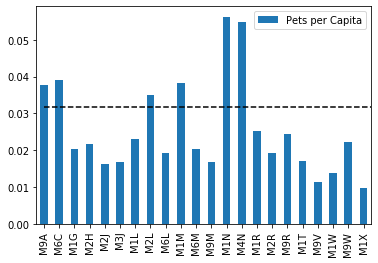

In [74]:
bar_chart=toronto_fsa_no_venues[['Postal Code','Pets per Capita']]
ax=bar_chart.plot.bar()
ax.set_xticklabels(bar_chart['Postal Code'])
ax.plot([0,21.5 ], [Pets_Per_Capita_Pet_Stores, Pets_Per_Capita_Pet_Stores], "k--")

In [75]:
#Creating map with folium
map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

for lat,lng,neighbourhood in zip(toronto_fsa_no_venues['Latitude'],toronto_fsa_no_venues['Longitude'],toronto_fsa_no_venues['Neighborhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

## Out of these 22 neighborhoods where petstores does not exist and also where the population is maximum, it will be advisable to open the pet store over there.

In [120]:
toronto_fsa_no_venues.sort_values(by='Population, 2016', ascending=False)
toronto_fsa_no_venues.reset_index()
toronto_fsa_no_venues_summary=toronto_fsa_no_venues[['Postal Code','Population, 2016','Total']]
toronto_fsa_no_venues_summary=toronto_fsa_no_venues_summary.sort_values(by='Population, 2016',ascending=False).reset_index()
toronto_fsa_no_venues_summary.drop(['index'],1).head()

,Postal Code,"Population, 2016",Total
0,M2J,58293.0,954
1,M9V,55959.0,636
2,M1W,48471.0,670
3,M6M,42434.0,863
4,M2R,40792.0,789


## If only one store needs to be opened, then it should open at the Postal Code M2J as these neighborhoods has max population and pets among the rest.

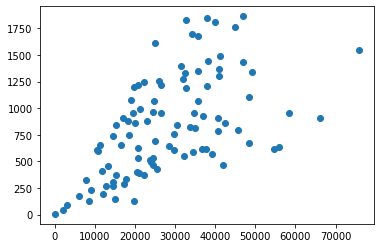

In [77]:
plt.scatter(df9_no_pet['Population, 2016'], df9_no_pet['Total'])

In [78]:
from scipy.stats import pearsonr
corr = pearsonr(df9_no_pet['Population, 2016'], df9_no_pet['Total'])
corr

(0.5709071593457398, 1.0230207282584393e-09)

## Which K-Means should we use?

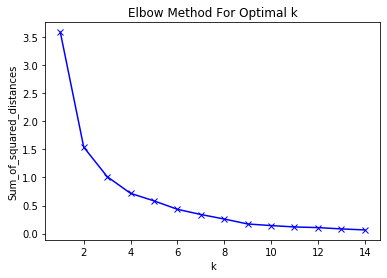

In [80]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
mms = MinMaxScaler()
data=toronto_fsa_no_venues[['Latitude','Longitude']]
mms.fit(data)
data_transformed = mms.transform(data)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [89]:
#Creating clusters
k=8
toronto_clustering = toronto_fsa_no_venues.drop(['Postal Code','Neighborhood','FSA','CAT','DOG','Geographic code','Geographic name','Province or territory','Incompletely enumerated Indian reserves and Indian settlements, 2016','Total private dwellings, 2016','Venue','Total','Population, 2016','Private dwellings occupied by usual residents, 2016','Venue','Pets per Capita'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)
kmeans.labels_
toronto_fsa_no_venues.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_fsa_no_venues

,Cluster Labels,Postal Code,Neighborhood,Latitude,Longitude,FSA,CAT,DOG,Total,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016",Venue,Pets per Capita
4,0,M9A,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,M9A,360,986,1346,M9A,M9A,Ontario,NaN,35594.0,15730.0,15119.0,NaN,0.037815
15,7,M6C,Humewood-Cedarvale,43.693781,-79.428191,M6C,239,725,964,M6C,M6C,Ontario,NaN,24596.0,11043.0,10484.0,NaN,0.039193
21,3,M1G,Woburn,43.770992,-79.216917,M1G,220,385,605,M1G,M1G,Ontario,NaN,29690.0,10116.0,9767.0,NaN,0.020377
26,1,M2H,Hillcrest Village,43.803762,-79.363452,M2H,168,361,529,M2H,M2H,Ontario,NaN,24497.0,9093.0,8700.0,NaN,0.021594
32,1,M2J,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,M2J,295,659,954,M2J,M2J,Ontario,NaN,58293.0,22524.0,21876.0,NaN,0.016366
33,2,M3J,"Northwood Park, York University",43.767980,-79.487262,M3J,160,268,428,M3J,M3J,Ontario,NaN,25473.0,10196.0,9407.0,NaN,0.016802
42,5,M1L,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,M1L,299,510,809,M1L,M1L,Ontario,NaN,35081.0,12884.0,12428.0,NaN,0.023061
43,4,M2L,"York Mills, Silver Hills",43.757490,-79.374714,M2L,91,319,410,M2L,M2L,Ontario,NaN,11717.0,4154.0,3974.0,NaN,0.034992
46,7,M6L,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,M6L,124,272,396,M6L,M6L,Ontario,NaN,20616.0,7611.0,7387.0,NaN,0.019208
48,5,M1M,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,M1M,250,627,877,M1M,M1M,Ontario,NaN,22913.0,8908.0,8623.0,NaN,0.038275


In [90]:
#Drawing clusters on the map
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(toronto_fsa_no_venues['Latitude'], toronto_fsa_no_venues['Longitude'], toronto_fsa_no_venues['Neighborhood'], toronto_fsa_no_venues['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [91]:
toronto_fsa_no_venues_tot_pop = pd.DataFrame(toronto_fsa_no_venues.groupby(['Cluster Labels'])['Population, 2016'].agg('sum'))
toronto_fsa_no_venues_tot_pop

,"Population, 2016"
Cluster Labels,
0,91600.0
1,195707.0
2,66265.0
3,44787.0
4,27047.0
5,80130.0
6,96643.0
7,87646.0


In [92]:
toronto_fsa_no_venues_tot_pets = pd.DataFrame(toronto_fsa_no_venues.groupby(['Cluster Labels'])['Total'].agg('sum'))
toronto_fsa_no_venues_tot_pets

,Total
Cluster Labels,
0,2545
1,3498
2,1217
3,753
4,1251
5,2931
6,1539
7,2223


In [93]:
toronto_cluster=pd.concat([toronto_fsa_no_venues_tot_pets,toronto_fsa_no_venues_tot_pop],axis=1,sort=False)

In [94]:
toronto_fsa_no_venues_pin_i=toronto_fsa_no_venues[['Cluster Labels','Postal Code']]
toronto_fsa_no_venues_clusters_pin_code = toronto_fsa_no_venues_pin_i.groupby(['Cluster Labels'],sort=False).agg(','.join)
toronto_fsa_no_venues_clusters_pin_code


,Postal Code
Cluster Labels,
0,"M9A,M9M,M9R"
7,"M6C,M6L,M6M"
3,"M1G,M1X"
1,"M2H,M2J,M1R,M1T,M1W"
2,"M3J,M2R"
5,"M1L,M1M,M1N"
4,"M2L,M4N"
6,"M9V,M9W"


In [95]:
toronto_cluster_final=pd.concat([toronto_cluster,toronto_fsa_no_venues_clusters_pin_code],axis=1,sort=False)
toronto_cluster_final

,Total,"Population, 2016",Postal Code
Cluster Labels,,,
0,2545,91600.0,"M9A,M9M,M9R"
1,3498,195707.0,"M2H,M2J,M1R,M1T,M1W"
2,1217,66265.0,"M3J,M2R"
3,753,44787.0,"M1G,M1X"
4,1251,27047.0,"M2L,M4N"
5,2931,80130.0,"M1L,M1M,M1N"
6,1539,96643.0,"M9V,M9W"
7,2223,87646.0,"M6C,M6L,M6M"


In [96]:
toronto_cluster_final=toronto_cluster_final.sort_values(by='Total',ascending=False)
toronto_cluster_final

,Total,"Population, 2016",Postal Code
Cluster Labels,,,
1,3498,195707.0,"M2H,M2J,M1R,M1T,M1W"
5,2931,80130.0,"M1L,M1M,M1N"
0,2545,91600.0,"M9A,M9M,M9R"
7,2223,87646.0,"M6C,M6L,M6M"
6,1539,96643.0,"M9V,M9W"
4,1251,27047.0,"M2L,M4N"
2,1217,66265.0,"M3J,M2R"
3,753,44787.0,"M1G,M1X"


In [100]:
toronto_cluster_final['Pets Per Capita']=toronto_cluster_final['Total']/toronto_cluster_final['Population, 2016']
toronto_cluster_final=toronto_cluster_final.reset_index()

In [101]:
toronto_cluster_final

,Cluster Labels,Total,"Population, 2016",Postal Code,Pets Per Capita
0,1,3498,195707.0,"M2H,M2J,M1R,M1T,M1W",0.017874
1,5,2931,80130.0,"M1L,M1M,M1N",0.036578
2,0,2545,91600.0,"M9A,M9M,M9R",0.027784
3,7,2223,87646.0,"M6C,M6L,M6M",0.025363
4,6,1539,96643.0,"M9V,M9W",0.015925
5,4,1251,27047.0,"M2L,M4N",0.046253
6,2,1217,66265.0,"M3J,M2R",0.018366
7,3,753,44787.0,"M1G,M1X",0.016813


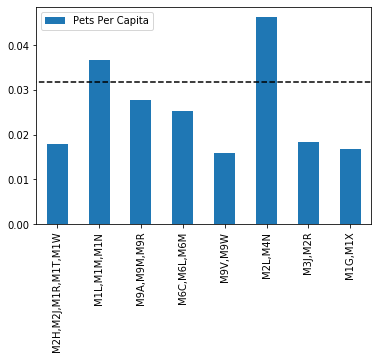

In [105]:
cluster_bar_chart=toronto_cluster_final[['Postal Code','Pets Per Capita']]
ax=cluster_bar_chart.plot.bar()
ax.set_xticklabels(cluster_bar_chart['Postal Code'])
ax.plot([-1,21.5 ], [Pets_Per_Capita_Pet_Stores, Pets_Per_Capita_Pet_Stores], "k--")